In [2]:
import pandas as pd

In [3]:
import sys
sys.version

'3.7.9 (v3.7.9:13c94747c7, Aug 15 2020, 01:31:08) \n[Clang 6.0 (clang-600.0.57)]'

In [4]:
#pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [5]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [6]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [7]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [8]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

## DJIA

In [9]:
dji = pd.read_csv("data/^DJI.csv")
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
test_dji = test_dji.reset_index(drop=True)

In [10]:
test_dji.shape

(1131, 7)

In [11]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


In [12]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [13]:
dow_strat = backtest_strat(test_dji)

## Ensemble Strategy

In [14]:
df=pd.read_csv('data/dow_30_2009_2020.csv')

In [15]:
rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()


In [16]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [17]:
ensemble_account_value = get_account_value('ensemble')

1.018313532239878


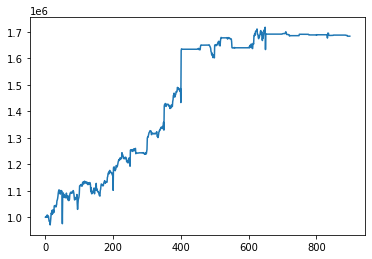

In [18]:
ensemble_account_value.account_value.plot()

In [19]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  1.018313532239878


In [20]:
ensemble_account_value['Date'] = test_dji['Date']

In [21]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1.000000e+06,20160104,NaN,2016-01-04
1,9.991265e+05,20160105,-0.000874,2016-01-05
2,1.002859e+06,20160106,0.003736,2016-01-06
3,9.999017e+05,20160107,-0.002949,2016-01-07
4,1.001227e+06,20160108,0.001325,2016-01-08


In [22]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [23]:
#ensemble_account_value.to_csv('results/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2016-01-04
End date,2019-07-31
Total months,42
,Backtest
Annual return,15.712%
Cumulative returns,68.402%
Annual volatility,15.502%
Sharpe ratio,1.02
Calmar ratio,1.35
Stability,0.85
Max drawdown,-11.607%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.61,2016-03-02,2016-03-16,2016-05-27,63
1,6.40,2016-10-04,2016-10-18,2016-10-19,12
2,4.95,2016-06-20,2016-08-23,2016-09-13,62
3,4.91,2018-08-01,2018-08-02,NaT,NaN
4,4.12,2016-11-23,2016-12-29,2016-12-30,28


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


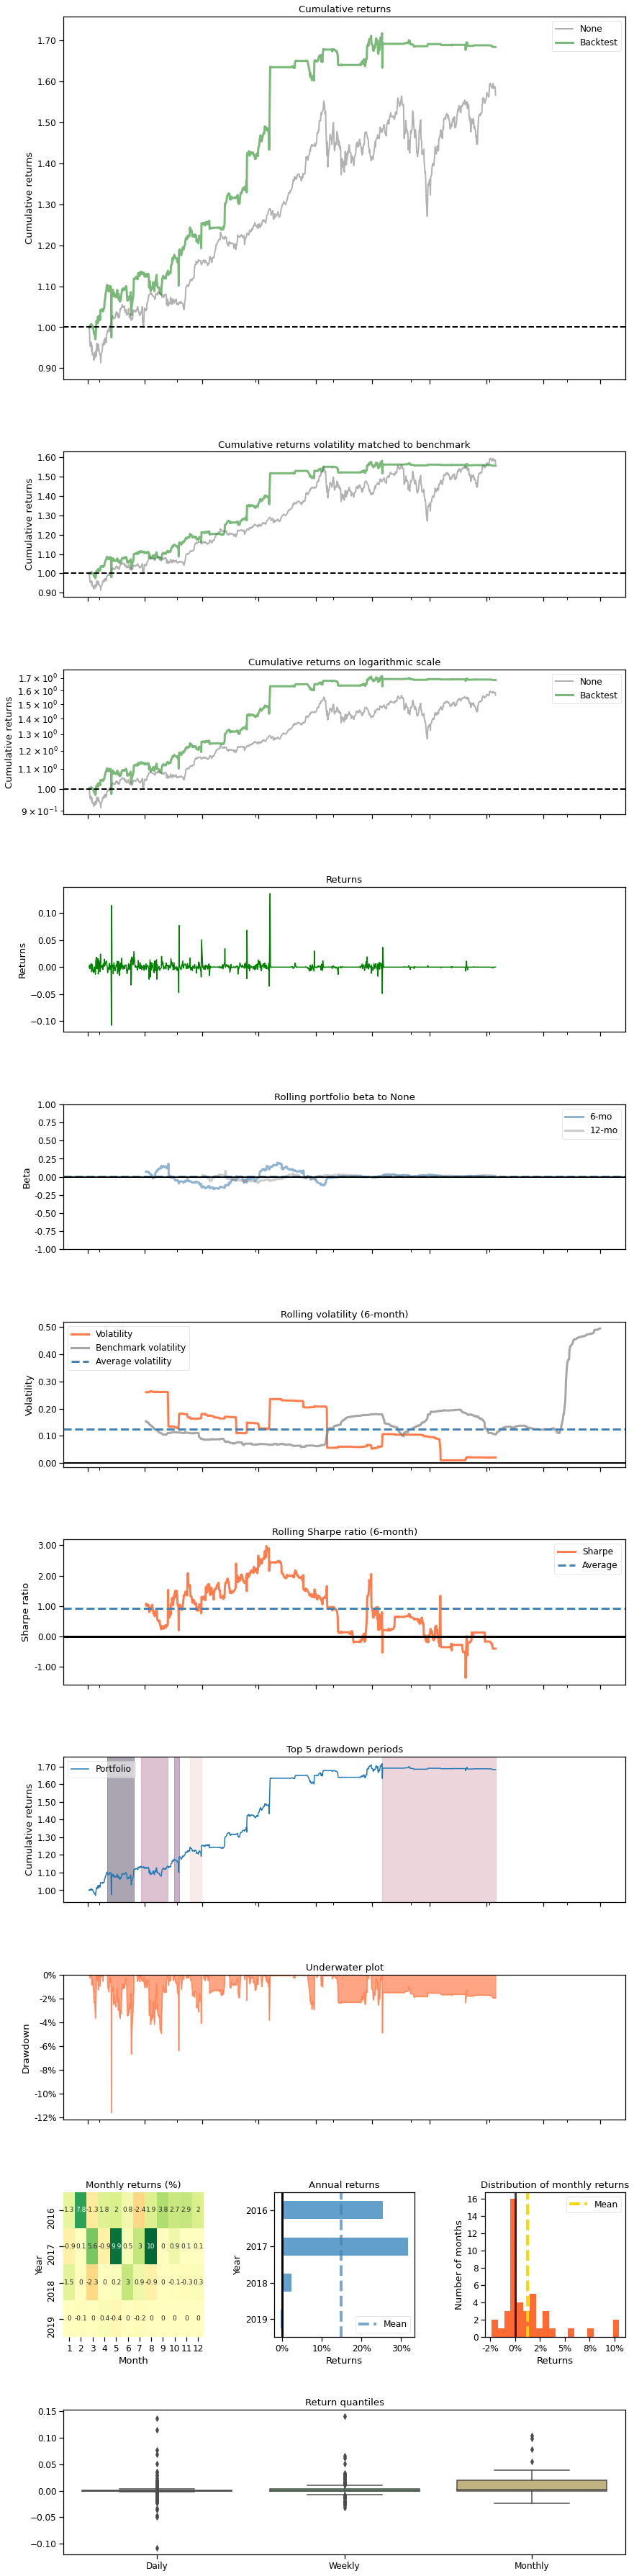

In [24]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)